# LSTMを、tensorflow+kerasで見ていきます
**が、単調な例はQiitaにたくさん記事があるので、ここではそれら参考となりそうな記事を紹介しつつ、**  
**今回は、もう少し発展的な内容をやっていきます。**

### 参考となりそうな LSTM関連のQiita記事
**[@sasayabaku氏 初心者のRNN(LSTM) | Kerasで試してみる](https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf)**  
**[@everylittle氏 Kerasで基本的なRNN (LSTM) を試してみる](https://qiita.com/everylittle/items/ba821e93d275a421ca2b)**  
**[Rosyuku氏 KerasでLSTMを学習する手順を整理してみた](https://own-search-and-study.xyz/2018/09/17/keras%E3%81%A7lstm%E3%82%92%E5%AD%A6%E7%BF%92%E3%81%99%E3%82%8B%E6%89%8B%E9%A0%86%E3%82%92%E6%95%B4%E7%90%86%E3%81%97%E3%81%A6%E3%81%BF%E3%81%9F/)**

### 今回扱うことは、Auto-Encoder LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import random

In [4]:
from keras.callbacks import EarlyStopping

In [6]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

In [8]:
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
#from tensorflow.random import set_seed
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

#### データの読み込み

In [11]:
# load, average and merge sensor samples
data_dir = './data/location10_data.csv'

In [12]:
df = pd.read_csv(data_dir, index_col=0)
df

,timestamp,location_id,device_id,variable1,variable2,variable3,variable4,variable5
0,2020-07-01 00:09:57,10,4,2.250,0.083,0.228,0.147,54.50
1,2020-07-01 00:09:58,10,5,1.602,0.098,0.187,0.173,58.30
2,2020-07-01 00:10:01,10,1,1.501,0.039,0.123,0.127,52.49
3,2020-07-01 00:10:01,10,3,1.487,0.106,0.117,0.093,61.58
4,2020-07-01 00:10:06,10,2,1.532,0.079,0.171,0.143,61.41
...,...,...,...,...,...,...,...,...
21595,2020-07-30 23:55:57,10,5,1.945,0.097,0.165,0.107,60.79
21596,2020-07-30 23:57:44,10,2,2.167,0.113,0.128,0.153,61.99
21597,2020-07-30 23:59:13,10,1,2.005,0.059,0.143,0.133,52.75
21598,2020-07-31 00:00:16,10,4,1.395,0.096,0.104,0.083,51.53


In [13]:
df_device1 = df[df['device_id']==1]

In [14]:
df_device1

,timestamp,location_id,device_id,variable1,variable2,variable3,variable4,variable5
2,2020-07-01 00:10:01,10,1,1.501,0.039,0.123,0.127,52.49
9,2020-07-01 00:20:06,10,1,1.511,0.038,0.191,0.110,55.93
13,2020-07-01 00:30:02,10,1,1.328,0.083,0.138,0.107,59.20
19,2020-07-01 00:40:04,10,1,2.108,0.080,0.174,0.160,60.38
24,2020-07-01 00:50:05,10,1,2.011,0.052,0.209,0.170,59.15
...,...,...,...,...,...,...,...,...
21577,2020-07-30 23:19:00,10,1,2.075,0.035,0.181,0.147,59.32
21582,2020-07-30 23:29:04,10,1,1.711,0.050,0.192,0.107,55.08
21587,2020-07-30 23:39:09,10,1,2.129,0.073,0.175,0.153,52.74
21592,2020-07-30 23:49:14,10,1,1.687,0.078,0.179,0.160,56.80


**LocationID, deviceIDをのぞき、1000ステップ分を使う**

In [10]:
df_device1 = df_device1.drop(columns=["location_id", "device_id", "variable5"]).set_index("timestamp")

In [11]:
df_device1

,variable1,variable2,variable3,variable4
timestamp,,,,
2020-07-01 00:10:01,1.501,0.039,0.123,0.127
2020-07-01 00:20:06,1.511,0.038,0.191,0.110
2020-07-01 00:30:02,1.328,0.083,0.138,0.107
2020-07-01 00:40:04,2.108,0.080,0.174,0.160
2020-07-01 00:50:05,2.011,0.052,0.209,0.170
...,...,...,...,...
2020-07-30 23:19:00,2.075,0.035,0.181,0.147
2020-07-30 23:29:04,1.711,0.050,0.192,0.107
2020-07-30 23:39:09,2.129,0.073,0.175,0.153


#### 学習用データと検証用データを用意する

In [12]:
# 555ステップの学習用データを用意
train_data = df_device1[:555]
len(train_data)

555

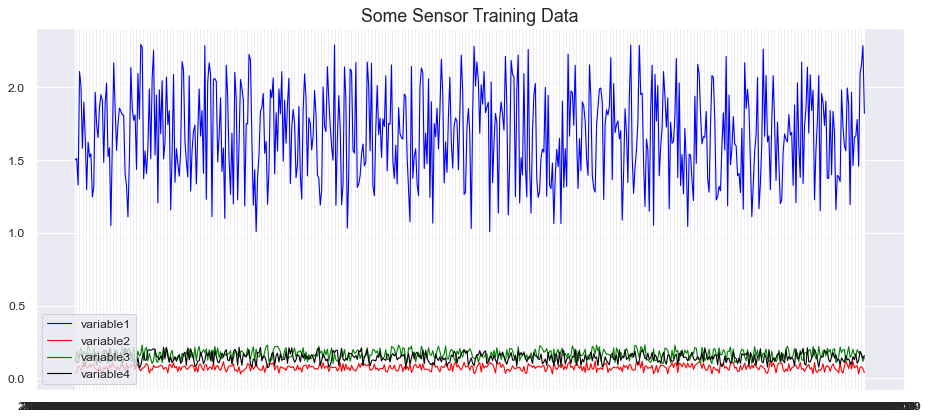

In [13]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_data['variable1'], label='variable1', color='blue', animated = True, linewidth=1)
ax.plot(train_data['variable2'], label='variable2', color='red', animated = True, linewidth=1)
ax.plot(train_data['variable3'], label='variable3', color='green', animated = True, linewidth=1)
ax.plot(train_data['variable4'], label='variable4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Some Sensor Training Data', fontsize=16)
plt.show()

In [14]:
# 高速フーリエ変換
train_fft = np.fft.fft(train_data)

In [15]:
train_fft

array([[1.79 +0.j   , 1.378+0.088j, 1.458+0.j   , 1.378-0.088j],
       [1.85 +0.j   , 1.32 +0.072j, 1.554+0.j   , 1.32 -0.072j],
       [1.656+0.j   , 1.19 +0.024j, 1.276+0.j   , 1.19 -0.024j],
       ...,
       [2.559+0.j   , 1.994+0.083j, 2.073+0.j   , 1.994-0.083j],
       [2.604+0.j   , 2.17 +0.072j, 2.2  +0.j   , 2.17 -0.072j],
       [2.161+0.j   , 1.678+0.117j, 1.767+0.j   , 1.678-0.117j]])

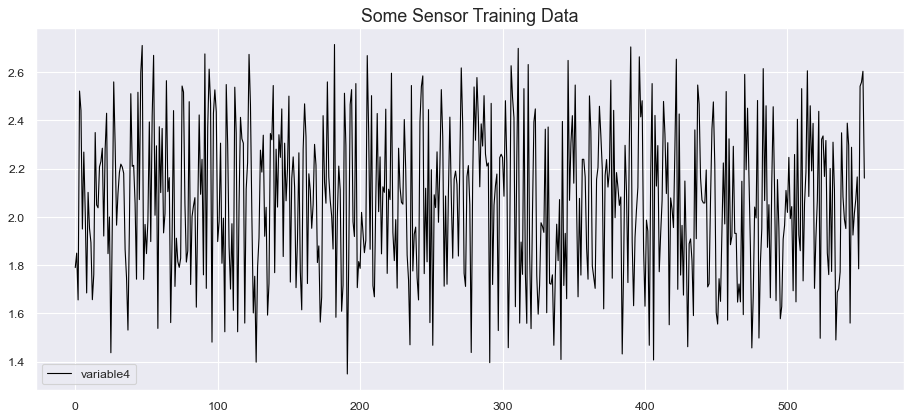

In [16]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='variable4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Some Sensor Training Data', fontsize=16)
plt.show()

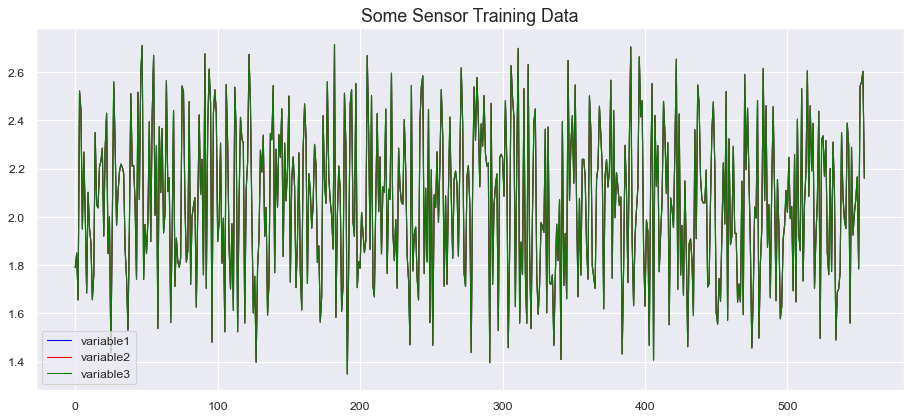

In [17]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='variable1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,0].real, label='variable2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,0].real, label='variable3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Some Sensor Training Data', fontsize=16)
plt.show()

In [13]:
# データの正規化
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [19]:
# 機械学習用データにReshape, LSTMへ適用 [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)

Training data shape: (555, 1, 4)


### Varational Auto-Encoderによる実験

### LSTM Auto-Encoderによる実験
**ESANN 2015**  


In [81]:
# Auto-Encoder LSTM Model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [85]:
# コンパイル
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)             

In [99]:
# Early-stopping 
early_stopping = EarlyStopping(patience=1E-10, verbose=10) 

In [100]:
# モデルにデータ適用
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05, callbacks=[early_stopping]).history

Epoch 1/100
53/53 [==============================] - 0s 7ms/step - loss: 0.1067 - val_loss: 0.0967
Epoch 2/100
53/53 [==============================] - 0s 9ms/step - loss: 0.1063 - val_loss: 0.0971
Epoch 00002: early stopping


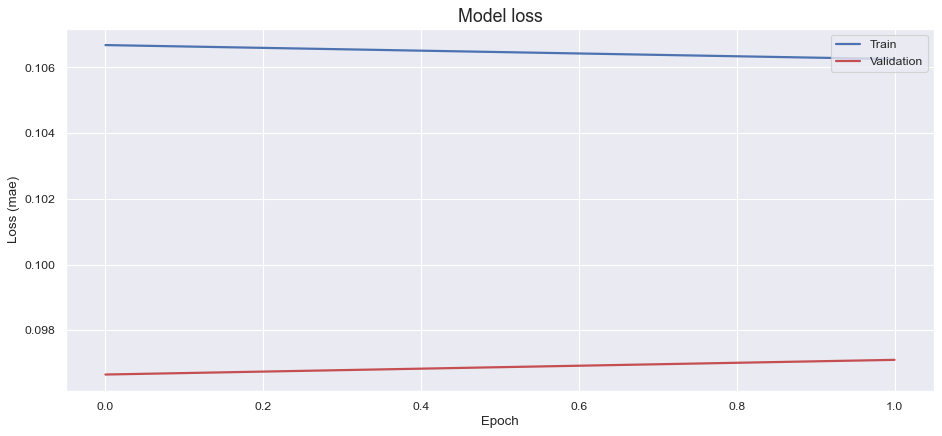

In [101]:
# モデル損失の可視化
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [104]:
# fit the model to the data
nb_epochs = 1000
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.1039 - val_loss: 0.0935
Epoch 2/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1039 - val_loss: 0.0919
Epoch 3/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1043 - val_loss: 0.0945
Epoch 4/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1041 - val_loss: 0.0923
Epoch 5/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1040 - val_loss: 0.0931
Epoch 6/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1039 - val_loss: 0.0926
Epoch 7/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1039 - val_loss: 0.0933
Epoch 8/1000
53/53 [==============================] - 1s 10ms/step - loss: 0.1037 - val_loss: 0.0944
Epoch 9/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1041 - val_loss: 0.0927
Epoch 10/1000
53/53 [==============================] - 1s 9ms/step - loss: 0.1041 - val_loss: 0.091

Epoch 82/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1038 - val_loss: 0.0927
Epoch 83/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1033 - val_loss: 0.0922
Epoch 84/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1033 - val_loss: 0.0925
Epoch 85/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1039 - val_loss: 0.0924
Epoch 86/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1035 - val_loss: 0.0923
Epoch 87/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1036 - val_loss: 0.0925
Epoch 88/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1036 - val_loss: 0.0919
Epoch 89/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1035 - val_loss: 0.0932
Epoch 90/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1035 - val_loss: 0.0930
Epoch 91/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1036 - val_los

53/53 [==============================] - 0s 7ms/step - loss: 0.1033 - val_loss: 0.0926
Epoch 243/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1032 - val_loss: 0.0925
Epoch 244/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1032 - val_loss: 0.0920
Epoch 245/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1032 - val_loss: 0.0934
Epoch 246/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1033 - val_loss: 0.0927
Epoch 247/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1032 - val_loss: 0.0936
Epoch 248/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1032 - val_loss: 0.0920
Epoch 249/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1031 - val_loss: 0.0926
Epoch 250/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1030 - val_loss: 0.0934
Epoch 251/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1031 - val_loss: 0.

53/53 [==============================] - 0s 7ms/step - loss: 0.1028 - val_loss: 0.0930
Epoch 403/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1032 - val_loss: 0.0920
Epoch 404/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1030 - val_loss: 0.0924
Epoch 405/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1027 - val_loss: 0.0912
Epoch 406/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1028 - val_loss: 0.0922
Epoch 407/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1028 - val_loss: 0.0922
Epoch 408/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1028 - val_loss: 0.0931
Epoch 409/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1028 - val_loss: 0.0921
Epoch 410/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1027 - val_loss: 0.0929
Epoch 411/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1029 - val_loss: 0.

53/53 [==============================] - 0s 6ms/step - loss: 0.1027 - val_loss: 0.0921
Epoch 563/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1028 - val_loss: 0.0914
Epoch 564/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1029 - val_loss: 0.0929
Epoch 565/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1026 - val_loss: 0.0923
Epoch 566/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1025 - val_loss: 0.0917
Epoch 567/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1033 - val_loss: 0.0926
Epoch 568/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1026 - val_loss: 0.0927
Epoch 569/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1031 - val_loss: 0.0931
Epoch 570/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1026 - val_loss: 0.0920
Epoch 571/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1027 - val_loss: 0.

53/53 [==============================] - 0s 6ms/step - loss: 0.1026 - val_loss: 0.0915
Epoch 723/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1026 - val_loss: 0.0933
Epoch 724/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1025 - val_loss: 0.0923
Epoch 725/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1027 - val_loss: 0.0922
Epoch 726/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1029 - val_loss: 0.0925
Epoch 727/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1024 - val_loss: 0.0923
Epoch 728/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1028 - val_loss: 0.0922
Epoch 729/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1027 - val_loss: 0.0926
Epoch 730/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1026 - val_loss: 0.0921
Epoch 731/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1022 - val_loss: 0.

53/53 [==============================] - 0s 7ms/step - loss: 0.1026 - val_loss: 0.0927
Epoch 883/1000
53/53 [==============================] - 0s 9ms/step - loss: 0.1028 - val_loss: 0.0927
Epoch 884/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.1025 - val_loss: 0.0927
Epoch 885/1000
53/53 [==============================] - 1s 11ms/step - loss: 0.1024 - val_loss: 0.0920
Epoch 886/1000
53/53 [==============================] - 1s 9ms/step - loss: 0.1028 - val_loss: 0.0932
Epoch 887/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.1024 - val_loss: 0.0927
Epoch 888/1000
53/53 [==============================] - 1s 9ms/step - loss: 0.1023 - val_loss: 0.0922
Epoch 889/1000
53/53 [==============================] - 0s 9ms/step - loss: 0.1026 - val_loss: 0.0924
Epoch 890/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1025 - val_loss: 0.0924
Epoch 891/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.1025 - val_loss: 0

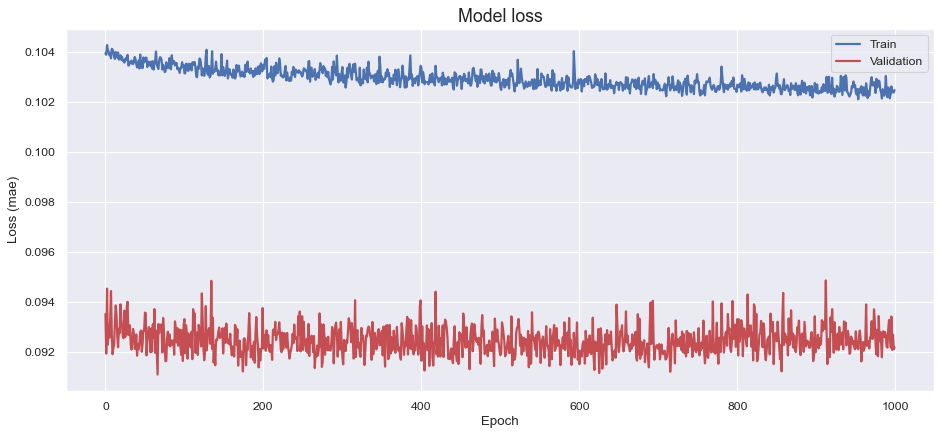

In [105]:
# 学習経過の可視化
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/Users/Toki/.pyenv/versions/3.7.4/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

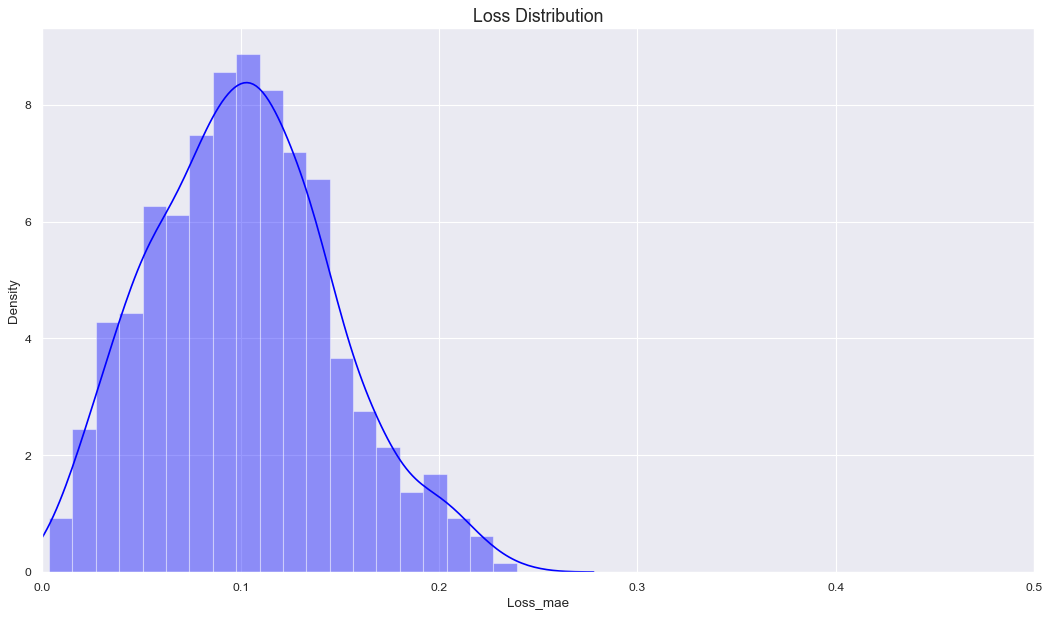

In [131]:
# MAEロスと頻度の可視化
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train_data.columns)
X_pred.index = train_data.index

scored = pd.DataFrame(index=train_data.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

#### 検証用データに徐々に消費電力が大きく(Variable4), トルクが下がるor抵抗が大きくなる(Variable4以外)を想定

In [14]:
# 555ステップの学習用データを用意
test_data = df_device1[555:1000]
len(test_data)

445

In [15]:
test_data_variable1 = test_data["variable1"].to_list()
test_data_variable2 = test_data["variable2"].to_list()
test_data_variable3 = test_data["variable3"].to_list()
test_data_variable4 = test_data["variable4"].to_list()

In [16]:
# 不規則な、電力の上昇(variable1)やトルクの低下(variable3,4)や抵抗の上昇(variable2)も模擬的に再現する
variable1 = []
variable2 = []
variable3 = []
variable4 = []
rand_num = random.randint(1,1000) / 10000
for i in range(len(test_data)):
    if i <= 245:
        variable1.append(test_data_variable1[i])
        variable2.append(test_data_variable2[i])
        variable3.append(test_data_variable3[i])
        variable4.append(test_data_variable4[i])
    if i > 245:
        rand_num += random.randint(1,1000) / 10000
        variable1.append(test_data_variable1[i]*(1+rand_num))
        variable2.append(test_data_variable2[i]*(1+rand_num))
        variable3.append(test_data_variable3[i]*(1-rand_num))
        variable4.append(test_data_variable4[i]*(1-rand_num))

In [17]:
len(variable1)

445

In [18]:
test_data["variable1"] = variable1
test_data["variable2"] = variable2
test_data["variable3"] = variable3
test_data["variable4"] = variable4

/Users/Toki/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Toki/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Toki/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

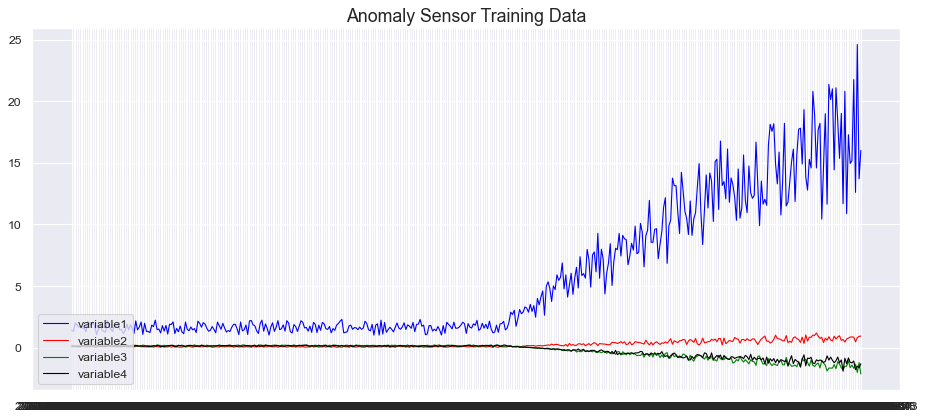

In [29]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_data['variable1'], label='variable1', color='blue', animated = True, linewidth=1)
ax.plot(test_data['variable2'], label='variable2', color='red', animated = True, linewidth=1)
ax.plot(test_data['variable3'], label='variable3', color='green', animated = True, linewidth=1)
ax.plot(test_data['variable4'], label='variable4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Anomaly Sensor Training Data', fontsize=16)
plt.show()

In [133]:
# 高速フーリエ変換
test_fft = np.fft.fft(test_data)

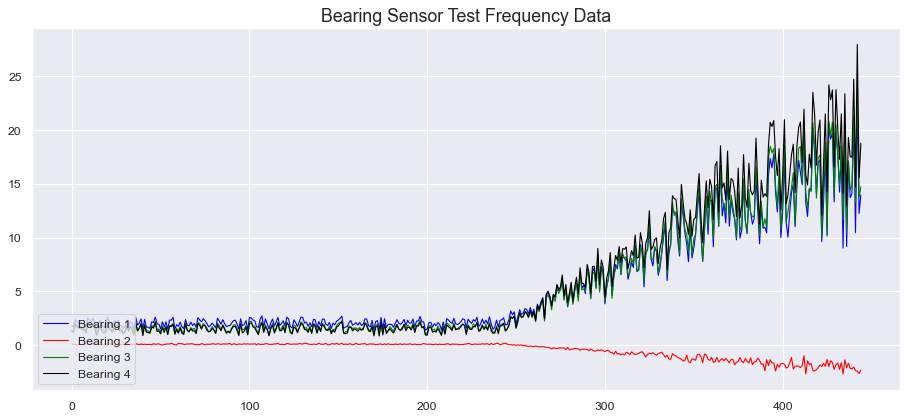

In [134]:
# うまくノイズを噛ませれたかの確認
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [19]:
X_test = scaler.transform(test_data)

In [136]:
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Test data shape: (445, 1, 4)


In [138]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_data.columns)
X_pred.index = test_data.index

scored = pd.DataFrame(index=test_data.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
timestamp,,,
2020-07-04 20:41:18,0.072672,0.275,False
2020-07-04 20:51:21,0.043556,0.275,False
2020-07-04 21:01:20,0.099740,0.275,False
2020-07-04 21:11:16,0.106770,0.275,False
2020-07-04 21:21:17,0.107015,0.275,False


In [139]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train_data.columns)
X_pred_train.index = train_data.index

scored_train = pd.DataFrame(index=train_data.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:xlabel='timestamp'>

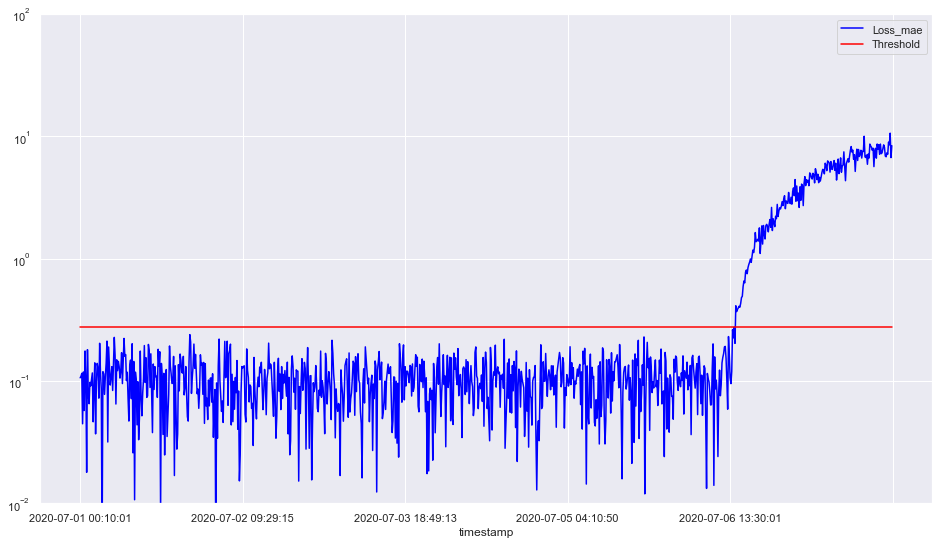

In [140]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])